**Note**: 

- The results below correspond to Analysis 1 in the paper.
- *Outputs*: 
    - Predictive accuracies of association using the combined model (reported in Figure 2A).
    - Variable coefficients in multiple logistic regression.
    - Figure 2A, 2B, 2C. 

In [1]:
import numpy as np
import pandas as pd
from scipy.sparse import load_npz, csr_matrix
from scipy.io import loadmat
from scipy.stats import pearsonr, spearmanr
import pickle as pk
from IPython.display import clear_output
import random
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.preprocessing import scale
import matplotlib as mpl
mpl.use('TkAgg')
%matplotlib inline
import seaborn as sns

sns.set_style('whitegrid')
sns.set_style("ticks", {"xtick.major.size": 0, "ytick.major.size": 8})

from pylab import rcParams

params = {'axes.spines.top'    : False,
          'axes.spines.right'  : False,
          'axes.labelsize': 10, 
          'axes.titlesize': 12,
          'font.size': 12, 
          'legend.fontsize': 12, 
          'xtick.labelsize': 10,
          'ytick.labelsize': 10,
          'ytick.direction':'in',
          'figure.figsize': [15,5],
          'font.family': 'serif',}

mpl.pyplot.rcParams.update(params)

In [2]:
matrices = loadmat('data/colexMats.mat')
size = matrices['135'].shape
min_NLang = 1

In [11]:
association = load_npz('data/hbc.npz')
frequency = load_npz('data/frequency.npz')
similarity = load_npz('data/w2v.npz')
concrete = load_npz('data/conc.npz')
valence = load_npz('data/valence.npz')

In [42]:
def printResult(list, ci = False):
    print('mean: ',round(np.mean(list),3))
    if ci == True: 
        print('95% ci: ', round(np.mean(list) - 1.96*np.std(list),3), round(np.mean(list) + 1.96*np.std(list),3))
    else: 
        print('mean ± std: ',round(np.mean(list) - np.std(list),3), round(np.mean(list) + np.std(list),3))

# Define binary matrix

In [30]:
"""If there is one language that colexifies a pair: 
    entry = 1 
else:
    entry = 0""" 

individual_binarize = {}

for i in matrices:
    if type(matrices[i]) == type(matrices['207']):
        ind = np.nonzero(matrices[i])
        mat = np.zeros(size)
        mat[ind] = 1 
        individual_binarize[i] = mat 

In [5]:
sumMat = sum(individual_binarize.values())

In [6]:
# Pairs that are identical in English

eng_ex = load_npz('data/eng_ex.npz')
english = set(zip(*np.nonzero(eng_ex)))

In [7]:
colexified = np.argwhere(sumMat >= min_NLang)
colex_set = set([tuple(i) for i in colexified]) - english

In [8]:
colex_ind = np.array(list(colex_set))
colex_ind = (colex_ind[:,0],colex_ind[:,1])

In [9]:
all_ind = list(zip(*np.indices(size).reshape(2, size[0]*size[0])))

In [10]:
zero_set = set(all_ind) - colex_set - english

# Perform multiple logistic regression

In [20]:
overall = []

for rep in range(100):
    clear_output(wait=True)
    print('Sample #: {}'.format(rep))
    sample_zero = random.sample(list(zero_set),len(colex_set))
    sample_zero = np.array(list(sample_zero))
    sample_zero = (sample_zero[:,0],sample_zero[:,1])
    
    target = np.array([1]*len(colex_set) + [0]*len(colex_set))
    
    association_array = list(association.toarray()[colex_ind]) + list(association.toarray()[sample_zero])
    frequency_array = list(frequency.toarray()[colex_ind]) + list(frequency.toarray()[sample_zero])
    similarity_array = list(similarity.toarray()[colex_ind]) + list(similarity.toarray()[sample_zero])
    concrete_array = list(concrete.toarray()[colex_ind]) + list(concrete.toarray()[sample_zero])
    valence_array = list(valence.toarray()[colex_ind]) + list(valence.toarray()[sample_zero])
    
    scale_asso = scale(association_array)
    scale_freq = scale(frequency_array)
    scale_sim = scale(similarity_array)
    scale_conc = scale(concrete_array)
    scale_val = scale(valence_array)
    
    target = target.reshape(-1,1)
    data = np.array(list(zip(*[scale_asso,scale_freq,scale_sim,scale_conc,scale_val])))
    
    acc = [] #Accuracy 
    
    for fold in range(10):
        X_train, X_test, y_train, y_test = \
        train_test_split(data, target, test_size=0.1)
        
        logistic = linear_model.LogisticRegression()
        model = logistic.fit(X_train, y_train)
        acc.append(model.score(X_test, y_test))
    
    overall.append(np.mean(acc))

Sample #: 99


In [40]:
print('-------------------------------------')
print('PREDICTIVE ACCURACY of COMBINED MODEL')
print('-------------------------------------')
printResult(overall)
print()

-------------------------------------
PREDICTIVE ACCURACY of COMBINED MODEL
-------------------------------------
mean:  0.685
mean ± std:  0.683 0.687



# Calculate variable coefficients

In [12]:
coeff = [] 

for rep in range(100):
    clear_output(wait=True)
    print('Sample #: {}'.format(rep))
    sample_zero = random.sample(list(zero_set),len(colex_set))
    sample_zero = np.array(list(sample_zero))
    sample_zero = (sample_zero[:,0],sample_zero[:,1])
    
    target = np.array([1]*len(colex_set) + [0]*len(colex_set))
    
    association_array = list(association.toarray()[colex_ind]) + list(association.toarray()[sample_zero])
    frequency_array = list(frequency.toarray()[colex_ind]) + list(frequency.toarray()[sample_zero])
    similarity_array = list(similarity.toarray()[colex_ind]) + list(similarity.toarray()[sample_zero])
    concrete_array = list(concrete.toarray()[colex_ind]) + list(concrete.toarray()[sample_zero])
    valence_array = list(valence.toarray()[colex_ind]) + list(valence.toarray()[sample_zero])
    
    scale_asso = scale(association_array)
    scale_freq = scale(frequency_array)
    scale_sim = scale(similarity_array)
    scale_conc = scale(concrete_array)
    scale_val = scale(valence_array)
    
    target = target.reshape(-1,1)
    data = np.array(list(zip(*[scale_asso,scale_freq,scale_sim,scale_conc,scale_val])))
        
    logistic = linear_model.LogisticRegression()
    logistic.fit(data, target)
    
    coeff.append(logistic.coef_[0])

Sample #: 99


In [13]:
coeff = np.array(coeff)
asso, freq, sim, conc, val = coeff[:,0],coeff[:,1],coeff[:,2],coeff[:,3],coeff[:,4]

In [44]:
title = ['HBC','FREQUENCY','W2V','CONCRETENESS','VALENCE']

for i in range(5):
    print('-------------------------------------')
    print('COEFFICIENT of {}'.format(title[i]))
    print('-------------------------------------')
    printResult(coeff[:,i], True)
    print()

-------------------------------------
COEFFICIENT of HBC
-------------------------------------
mean:  1.02
95% ci:  0.736 1.304

-------------------------------------
COEFFICIENT of FREQUENCY
-------------------------------------
mean:  0.307
95% ci:  0.275 0.339

-------------------------------------
COEFFICIENT of W2V
-------------------------------------
mean:  1.094
95% ci:  1.063 1.126

-------------------------------------
COEFFICIENT of CONCRETENESS
-------------------------------------
mean:  -0.157
95% ci:  -0.172 -0.142

-------------------------------------
COEFFICIENT of VALENCE
-------------------------------------
mean:  -0.1
95% ci:  -0.115 -0.086



# Correlation matrix

In [17]:
corr = np.zeros((5,5))
p = np.zeros((5,5))
preds = pd.read_csv('inputs.csv')

for i in range(5):
    for j in range(5):
        corr[i,j] = round(spearmanr(preds[str(i)],preds[str(j)])[0],2)
        p[i,j] = spearmanr(preds[str(i)],preds[str(j)])[1]

# Figure 2

In [16]:
x = ['Association (HBC)']*len(asso) + ['Frequency']*len(asso) + ['Similarity (w2v)']*len(asso) +\
['Metaphor (Concreteness)']*len(asso) + ['Metphor (Valence)']*len(asso)
y = list(asso) + list(freq) + list(sim) + list(conc) + list(val)

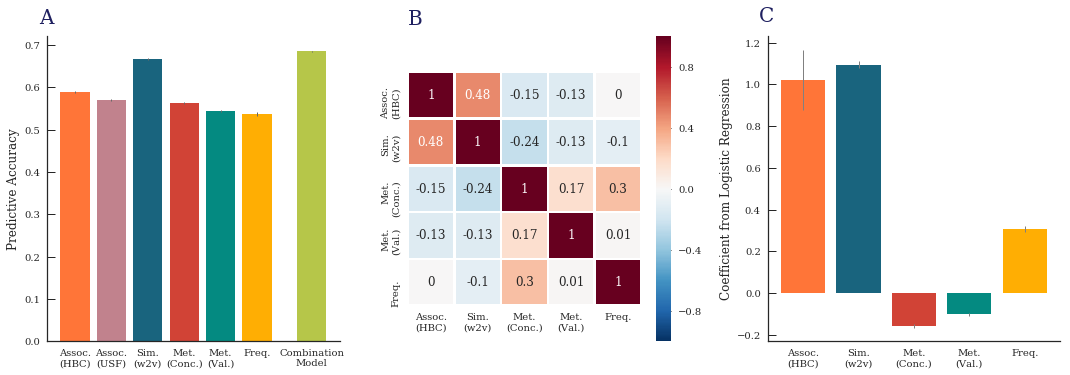

In [29]:
mean = [0.589, 0.571, 0.667, 0.564, 0.545, 0.538, 0.685]
std = [0.002,0.002,0.002, 0.002,0.002,0.005,0.002] 

ax1 = mpl.pyplot.subplot(131)

ax1.bar(list(range(6)) + [6.5],mean,
       align = 'center', edgecolor = 'none',
       color = ('#ff7538','#c1828d','#19647e',  '#d14336','#048a81', '#ffae03','#b6c649'),
       yerr=std, error_kw=dict(ecolor='dimgray', lw=1))

mpl.pyplot.xticks(list(range(6)) + [6.5], ('Assoc.\n(HBC)', 'Assoc.\n(USF)',
                                  'Sim.\n(w2v)','Met.\n(Conc.)',
                                  'Met.\n(Val.)', 'Freq.','Combination\nModel'))

ax1.yaxis.set_ticks_position('left')
ax1.xaxis.set_ticks_position('bottom')
mpl.pyplot.ylabel('Predictive Accuracy', size = 12)

error = [np.std(i) for i in [asso, sim, conc, val, freq]]

ax3 = mpl.pyplot.subplot(133)

ax3.bar(np.linspace(0, 2.5, 5),
       [np.mean(i) for i in [asso, sim, conc, val, freq]],
       align = 'center', width = 0.5, edgecolor = 'none',
       color = ('#ff7538','#19647e',  '#d14336','#048a81', '#ffae03'),
       yerr=error, error_kw=dict(ecolor='grey', lw=1))

mpl.pyplot.xticks(np.linspace(0, 2.5, 5), ('Assoc.\n(HBC)', 'Sim.\n(w2v)','Met.\n(Conc.)',
                   'Met.\n(Val.)', 'Freq.'))

ax3.yaxis.set_ticks_position('left')
ax3.xaxis.set_ticks_position('bottom')
mpl.pyplot.ylabel('Coefficient from Logistic Regression', size = 12)

ax2 = mpl.pyplot.subplot(132)
sns.heatmap(corr, annot = True,
            vmin = -1, vmax = 1,
            linecolor = 'white',linewidths = 1.5,square = True, ax = ax2,
           xticklabels = ['Assoc.\n(HBC)', 'Sim.\n(w2v)','Met.\n(Conc.)',
                   'Met.\n(Val.)', 'Freq.'],
           yticklabels = ['Assoc.\n(HBC)', 'Sim.\n(w2v)','Met.\n(Conc.)',
                   'Met.\n(Val.)', 'Freq.'])
mpl.pyplot.tight_layout()


ax1.set_title(' ')
ax2.set_title(' ')
ax3.set_title(' ')
ax1.text(-1,0.75,'A', size = 20, color = '#1F2060')
ax2.text(0,6,'B', size = 20, color = '#1F2060')
ax3.text(-0.5,1.3,'C', size = 20, color = '#1F2060')


mpl.pyplot.savefig('accuracy_log.png', format='eps', dpi=600,bbox_inches='tight')
mpl.pyplot.show()